# LANL Earthquake Prediction Challenge
https://www.kaggle.com/c/LANL-Earthquake-Prediction

## Data description

### File descriptions

    train.csv - A single, continuous training segment of experimental data.
    test - A folder containing many small segments of test data.
    sample_sumbission.csv - A sample submission file in the correct format.

### Data fields

    acoustic_data - the seismic signal [int16]
    time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
    seg_id - the test segment ids for which predictions should be made (one prediction per segment)
    
### Science

    https://doi.org/10.1002/2017GL074677
    https://doi.org/10.1002/2017GL076708
    https://rdcu.be/bdG8Y
    https://rdcu.be/bdG9r


### Library import

In [1]:
# Library import 
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from pandas import Series
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

/Users/manuelfreude/anaconda3/envs/tensorflow/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Unzipping the relevant files
# ONE-TIME EXERCISE ONLY
"""
from zipfile import ZipFile

os.makedirs('LANL-Earthquake-Prediction')
train_zf = ZipFile('LANL-Earthquake-Prediction.zip', 'r')
train_zf.extractall('LANL-Earthquake-Prediction')
train_zf.close()
totals_train = 0
for root, dirs, files in os.walk('LANL-Earthquake-Prediction'): 
    totals_train += len(files)
print('There are %d total files.' % totals_train)"""

"\nfrom zipfile import ZipFile\n\nos.makedirs('LANL-Earthquake-Prediction')\ntrain_zf = ZipFile('LANL-Earthquake-Prediction.zip', 'r')\ntrain_zf.extractall('LANL-Earthquake-Prediction')\ntrain_zf.close()\ntotals_train = 0\nfor root, dirs, files in os.walk('LANL-Earthquake-Prediction'): \n    totals_train += len(files)\nprint('There are %d total files.' % totals_train)"

In [3]:
# Unzipping the relevant files
# ONE-TIME EXERCISE ONLY
"""
os.makedirs('LANL-Earthquake-Prediction/test')
test_zf = ZipFile('LANL-Earthquake-Prediction/test.zip', 'r')
test_zf.extractall('LANL-Earthquake-Prediction/test')
test_zf.close()
totals_test = 0
for root, dirs, files in os.walk('LANL-Earthquake-Prediction/test'): 
    totals_test += len(files)
print('There are %d total files.' % totals_test)"""

"\nos.makedirs('LANL-Earthquake-Prediction/test')\ntest_zf = ZipFile('LANL-Earthquake-Prediction/test.zip', 'r')\ntest_zf.extractall('LANL-Earthquake-Prediction/test')\ntest_zf.close()\ntotals_test = 0\nfor root, dirs, files in os.walk('LANL-Earthquake-Prediction/test'): \n    totals_test += len(files)\nprint('There are %d total files.' % totals_test)"

### First look at the data

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [4]:
train_df = pd.read_csv('LANL-Earthquake-Prediction/train.csv', 
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

pd.options.display.precision = 15
train_df.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


In [6]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


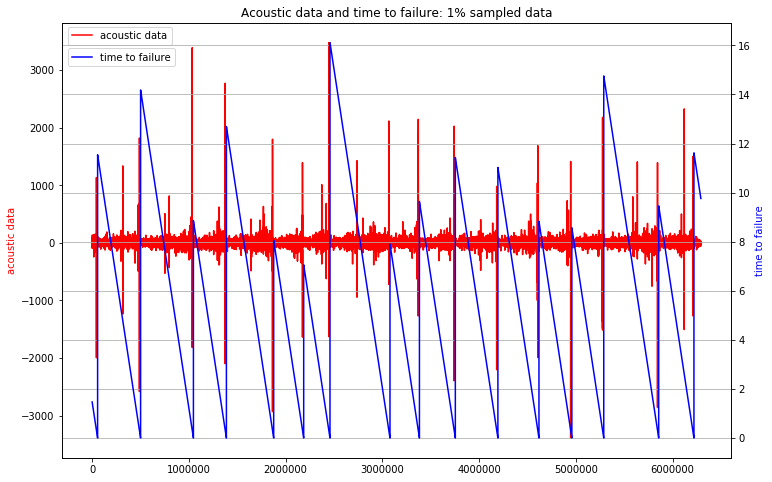

In [7]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

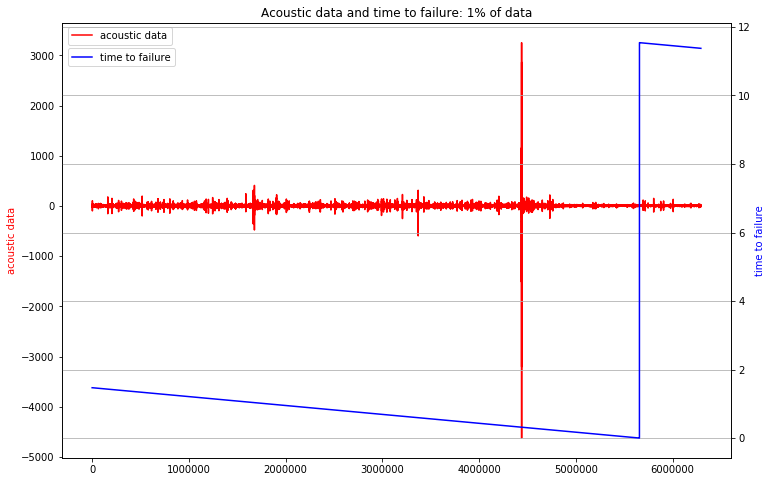

In [8]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

### Feature engineering

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

Further ideas along papers: 

- Kurtosis (https://en.wikipedia.org/wiki/Kurtosis)
- Autocorrelation (https://en.wikipedia.org/wiki/Autocorrelation)

In [9]:
# The test segments are 150,000 each.
# We split the train data in segments of the same dimmension with the test sets.
# We will create additional aggregation features, calculated on the segments.

rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [11]:
# Let's define some computation helper functions.

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [12]:
# Based on source

def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

##### Train data processing

In [13]:
# Processing the train data

train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [14]:
# Iterate over all segments
# Takes about 45 min with local machine

for seg_id in range(segments):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

train_X.shape

(4194, 154)

In [15]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Columns: 154 entries, mean to abs_max_roll_mean_1000
dtypes: float64(154)
memory usage: 4.9 MB


In [16]:
# Scaling the data

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,1.199316205489369,-0.105006593381723,1.424140499795018,0.156736086729651,-0.567194588224215,-0.169052005333305,...,0.268470130890001,-0.004741890462161,0.178277723969481,0.287332145975991,0.965402446610929,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.078885810556771,-0.008598597346281,0.805716032556438,-0.222117948425051,-0.485093757384045,0.007211752080005,...,-0.141264321988320,0.007341389309125,-0.025386948237320,0.622391465890732,0.842747052156309,0.522427542165818,0.294356817530996,-0.912053970881953,-0.890022480697742,0.007341389309125
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,0.078885810556770,0.043799511533280,1.511155259373636,-0.104253774698728,0.220973387841424,0.054839360725539,...,0.085078050610279,0.099555892826834,0.245184093558079,0.634878148620475,1.207105723918564,1.530919442793446,0.889790131706233,0.441127926802558,0.639209280695772,0.099555892826834
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.078885810556771,0.044798043493984,1.494934375107485,-0.033850788412464,0.516536378866038,0.042216538302113,...,0.083084874365199,0.068075769212167,0.105059432721582,0.770150544859347,1.160208073097680,1.432972387696517,0.815077966809722,-0.949993650256284,-1.097513494373596,0.068075769212167
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,1.199316205489368,0.078652301654897,1.520242078970566,-0.056323939067857,0.204553221673390,0.086841682459309,...,-0.164150560726067,0.138031599466982,0.187535209069790,1.040695337337088,1.557034349274394,1.393068031916287,0.901110156690553,0.595415956258175,-0.465464227208672,0.138031599466982
5,1.538962489544185,-0.131053986788160,-0.078960760198664,0.019686917428235,1.519439175470111,-0.073279455182016,1.538962489544182,0.016520649604222,0.089612058497151,-0.134763478369498,...,0.257139361692816,0.061716148279912,0.239713761453351,0.699392676057474,1.120525445480008,1.741324227816475,1.193166801286013,-1.382505995123670,0.273910179965897,0.061716148279912
6,1.313015726042317,-0.101218785996422,-0.159569193537274,0.268666562505451,-0.721421614395085,-0.065897706573636,1.313015726042313,0.026620944137275,-0.304471929535669,-0.098334074796606,...,-0.218669699063587,-0.031134317331023,0.204367000161261,0.730609382881830,1.416341396811739,1.059322510845276,0.627165552070007,-0.031853409397449,0.021835030421887,-0.031134317331023
7,-0.054824008985421,-0.081617152532347,-0.089952819290292,0.057411106076298,-0.241237159423971,-0.099902265987057,-0.054824008985424,-0.027098806829572,0.262023803261509,-0.076354258709420,...,-0.224789724471834,-0.147515380391304,0.007014249613762,0.220736504750701,0.132067266639831,-0.213989205414785,-0.316924531622290,-0.514951993430610,0.114835774764259,-0.147515380391304
8,0.774732321036825,0.145943916470089,0.016303751928785,-0.025582108949441,-0.561360129404713,0.098087075492250,0.774732321036822,-0.342872656184990,-0.238791264863532,0.147895339130580,...,-0.081652975344229,0.023240441639764,0.193847130729092,0.466307931768960,0.734521704108117,0.660278953042976,0.552453387173494,0.848347152087057,-0.227912239275442,0.023240441639764
9,0.825998647072221,0.040204715451199,-0.042320563226568,0.087590456994748,0.078885810556771,0.015541887002806,0.825998647072220,0.050997446880598,-0.008908938511054,0.046142156416401,...,0.030452666809819,-0.070245986064396,0.151346858223127,0.532903572994250,0.684016541685625,0.747343002018023,0.380389007411829,1.943539230026109,-1.024070155238219,-0.070245986064396


##### Test data processing

In [17]:
submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [18]:
# Iterate over all segments
# Takes about XX min with local machine

for seg_id in test_X.index:
    seg = pd.read_csv('LANL-Earthquake-Prediction//test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)
    
test_X.shape

(2624, 154)

In [19]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2624 entries, seg_00030f to seg_ffe7cc
Columns: 154 entries, mean to abs_max_roll_mean_1000
dtypes: float64(154)
memory usage: 3.2+ MB


In [20]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

scaled_test_X.shape

(2624, 154)

In [21]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942296902,-0.350098217792172,0.329025264342352,-0.081175674433601,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.074589603183191,-0.265116961140863,...,-0.131863367972886,-0.197756385756125,0.067608697543058,-0.245432983826332,-0.755380587355362,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103312901,-0.390402434461477,0.400701222773672,0.559070265527885,-0.271490841421192,-0.734695164615847,0.457524666141680,0.368754883353731,-0.320648190853422,...,-0.090273729721340,-0.210475627620636,-0.012763104918716,-0.420246542042718,-0.632725192900742,-0.772650186338005,-0.620301201202069,0.066789756975814,0.379958267345616,-0.210475627620636
2616,-2.073321685925087,0.185999424044961,0.045615909506462,0.027231755157847,0.238947295547141,0.058192651768876,-2.073321685925090,-0.198272835507732,-0.304471929535669,0.182882262889467,...,-0.335397473385972,-0.255310955193040,-0.100709213371653,-0.919713851232396,-1.650043464553771,-2.114887608036642,-1.421758970091934,-0.681886582677671,-0.455029743769391,-0.255310955193040
2617,-0.427930383839279,-0.291596382506079,-0.196209390509370,0.310163170018320,0.238947295547143,-0.242327244436703,-0.427930383839283,0.412107554533329,0.171712889337321,-0.293675558394082,...,-0.306297807314964,-0.147833361437917,0.084019693857243,-0.076862766974816,-0.026663243830852,-0.547734726485800,-0.409748736493715,0.491714165968333,0.259853681784336,-0.147833361437917
2618,-3.374741716678421,-0.152003490043633,-0.298801942031238,0.234714792722194,-0.721421614395085,-0.249113638779983,-3.374741716678424,0.271951919845560,0.007511227656980,-0.156716904848106,...,-0.176297932752017,-0.424476871991044,-0.208011881579782,-1.854133942174751,-3.157983314025280,-3.239464907297666,-2.157560594072741,-0.466895066223123,-0.517982573703920,-0.424476871991044
2619,-1.654729139621841,-0.172408272635962,-0.339106158700543,0.374294290720027,-1.041544584375828,-0.215590231150948,-1.654729139621846,0.224509483145720,0.532956545034073,-0.166937482945480,...,-0.035382823436088,-0.240683827048852,-0.014025489250577,-0.663736855272686,-1.487705442481479,-1.469162578138378,-0.817269635929239,0.643472883465663,-0.554972820552376,-0.240683827048852
2620,-1.487885758598570,-0.060792925011241,0.001647673139947,-0.221747889919369,0.238947295547142,-0.124402235161050,-1.487885758598571,0.230258375488919,-0.074589603183191,-0.063658336471214,...,0.301725399442915,-0.128754498641149,-0.147417433650486,-1.354666632985074,-2.028832182722451,-1.425630553650856,-0.894245805822615,1.559083812366209,-0.820948539836463,-0.128754498641149
2621,-3.010670087956753,0.343254632011228,0.536594548932544,-0.580127682075968,-0.241237159423971,0.174257853534564,-3.010670087956756,-0.487617919728305,-1.043379407097206,0.340983182941972,...,-0.166314501054057,-0.130344403874213,-0.335933493874962,-1.564859125602396,-2.624071596987521,-2.956506748128763,-1.935688104380066,1.604611427615407,-0.954385032173800,-0.130344403874213
2622,-0.694312192710866,0.782096807867043,0.727123573187442,-0.640486383912869,-0.241237159423972,0.628381731544477,-0.694312192710869,-1.113687307556833,0.762838871386551,0.778366527088963,...,-0.045220121607113,0.055356527347656,-0.178977041946994,-0.303704169898461,-0.679622843721626,-0.761767180216124,0.006828182929265,0.916638574960853,1.362109444329824,0.055356527347656
2623,-1.248764408517769,-0.349888468230894,-0.331778119306124,0.347887358666383,0.238947295547142,-0.306138783032271,-1.248764408517773,0.388179518203963,-0.230581181779515,-0.350400284361962,...,-0.256027867555159,-0.247997391120946,0.047831343010580,-0.497247752209461,-0.97183

### Scoring

Submissions are evaluated using the mean absolute error between the predicted time remaining before the next lab earthquake and the act remaining time.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [22]:
from sklearn.metrics import mean_absolute_error

scores = pd.DataFrame(columns=['Regressor', 'MAE'])

### Run first model and feature importance along source

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [23]:
# We define the folds for cross-validation.

n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [24]:
# We define the model parameters.

params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [25]:
# LightGBM https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

# We run the model. During training for each fold, we validate using the validation set 
# and also we predict using the current model for test set. The final result will be the 
# average over the all folds for the predictions done at each fold training.

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
# Run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.91738	valid_1's l1: 2.23804
[2000]	training's l1: 1.48754	valid_1's l1: 2.11454
[3000]	training's l1: 1.2384	valid_1's l1: 2.09552
Early stopping, best iteration is:
[3514]	training's l1: 1.13668	valid_1's l1: 2.09377
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.90548	valid_1's l1: 2.28968
[2000]	training's l1: 1.48874	valid_1's l1: 2.13765
[3000]	training's l1: 1.24188	valid_1's l1: 2.11321
Early stopping, best iteration is:
[3712]	training's l1: 1.10402	valid_1's l1: 2.11011
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.92808	valid_1's l1: 2.19709
[2000]	training's l1: 1.50316	valid_1's l1: 2.06017
[3000]	training's l1: 1.25264	valid_1's l1: 2.03559
[4000]	training's l1: 1.06292	valid_1's l1: 2.03323
Early stopping, best iteration is:
[3935]	training's l1: 1.07419	valid_1's l1: 2.03304


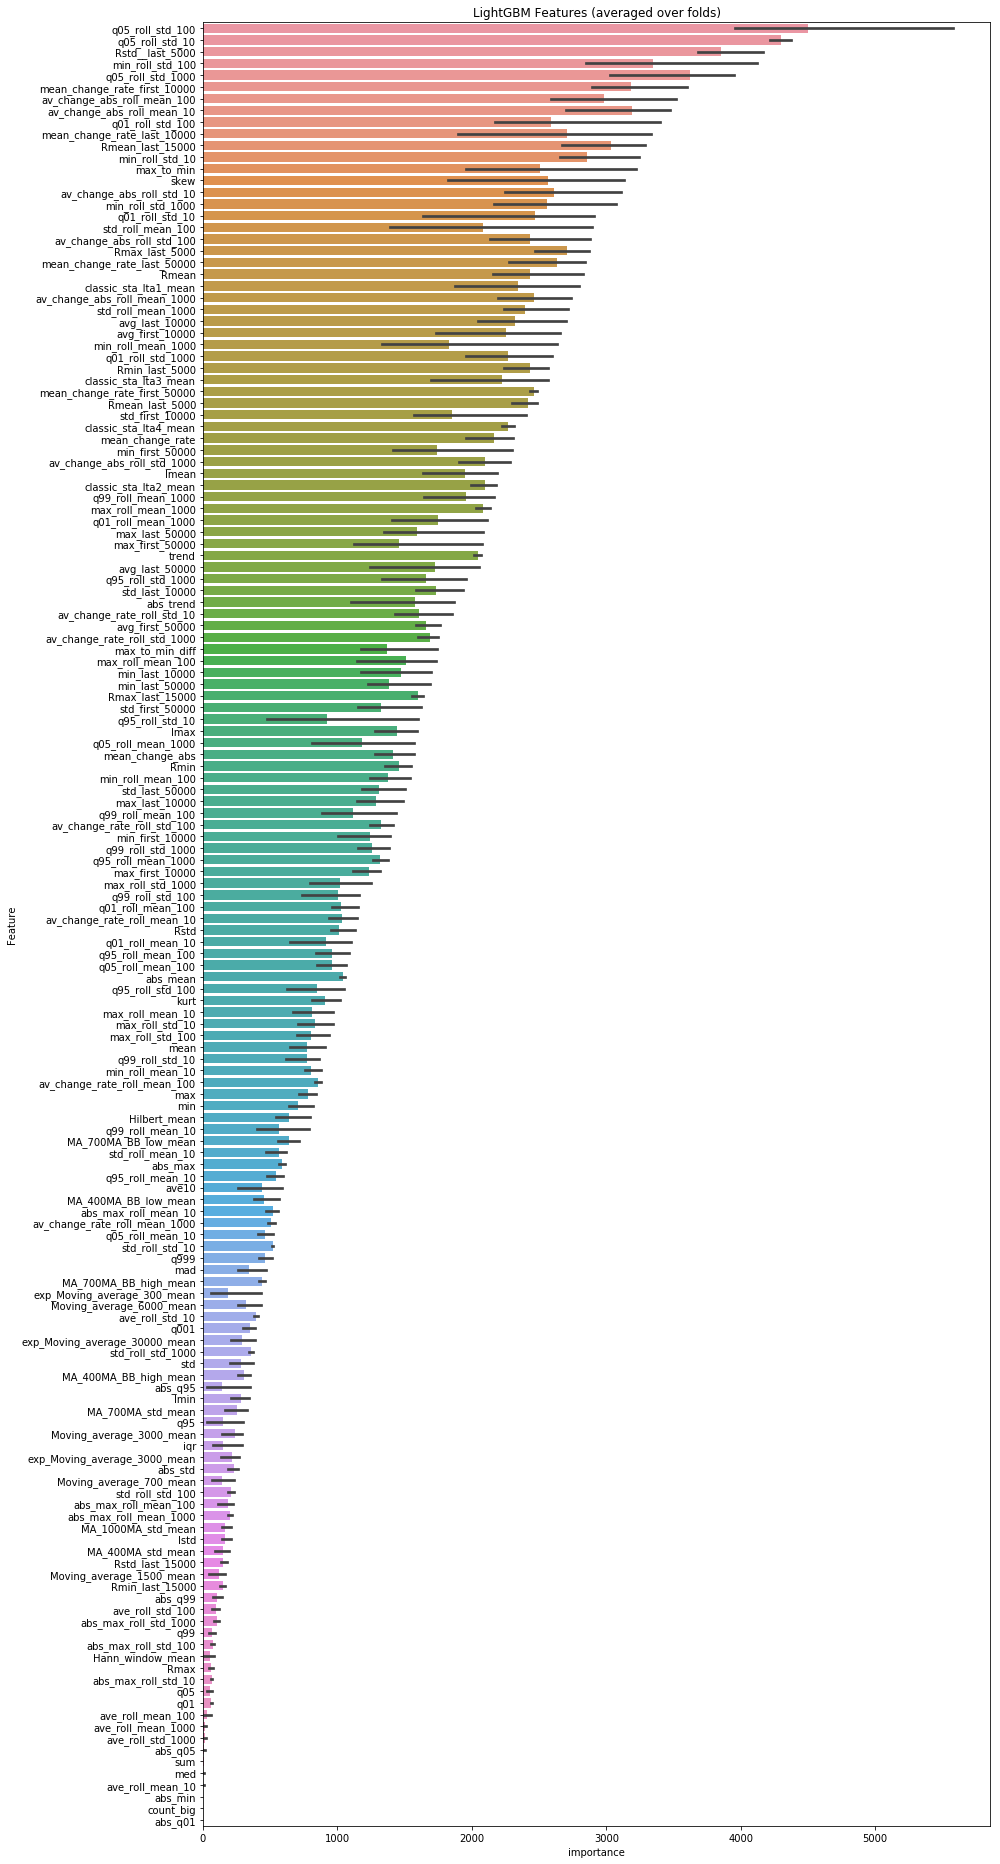

In [26]:
# Let's print features importance.

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### Model selection and hyperparameter optimization

The following algorithms will be applied for the model selection: 

- LightGBM https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
- SVR https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- Linear SVR http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR
- ElasticNet http://scikit-learn.org/stable/modules/linear_model.html#elastic-net
- Lasso http://scikit-learn.org/stable/modules/linear_model.html#lasso
- SGD https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
- Decision tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- Random forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- Bagging https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
- Gradient boosting https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
- MLP http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- AdaBoost http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
- XGBoost https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

#### Scoring

Submissions are evaluated using the mean absolute error between the predicted time remaining before the next lab earthquake and the act remaining time.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [44]:
from sklearn.metrics import mean_absolute_error

scores = pd.DataFrame(columns=['Regressor', 'MAE'])

In [27]:
# Defining number of cross-validations

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

##### LightGBM

In [45]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1, random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'LightGBM'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95662	valid_1's l1: 2.25816
[2000]	training's l1: 1.56609	valid_1's l1: 2.1319
[3000]	training's l1: 1.33658	valid_1's l1: 2.1101
Early stopping, best iteration is:
[3483]	training's l1: 1.24737	valid_1's l1: 2.10738
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.94985	valid_1's l1: 2.27454
[2000]	training's l1: 1.55936	valid_1's l1: 2.14583
[3000]	training's l1: 1.33423	valid_1's l1: 2.12445
[4000]	training's l1: 1.15998	valid_1's l1: 2.11988
Early stopping, best iteration is:
[4415]	training's l1: 1.09734	valid_1's l1: 2.11845
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95781	valid_1's l1: 2.2821
[2000]	training's l1: 1.57186	valid_1's l1: 2.11934
[3000]	training's l1: 1.34378	valid_1's l1: 2.08596
[4000]	training's l1: 1.16716	valid_1's l1: 2.0791
Early stopping, best iteration is:
[4561]	traini

##### SVR

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.svm import SVR

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = SVR(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'SVR'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### LinearSVR

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

from sklearn.svm import LinearSVR

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = LinearSVR(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'LinearSVR'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### ElasticNet

In [ ]:
# http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

from sklearn.linear_model import ElasticNet

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = ElasticNet(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'ElasticNet'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Lasso

In [ ]:
# http://scikit-learn.org/stable/modules/linear_model.html#lasso

from sklearn import linear_model

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = linear_model.Lasso(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'Lasso'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Stochastic Gradient Descent

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

from sklearn.linear_model import SGDRegressor

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = SGDRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'SGD'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Decision Tree

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

from sklearn.tree import DecisionTreeRegressor

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = DecisionTreeRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'Decision Tree'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Random Forest (top-performing in their first paper)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

from sklearn.ensemble import RandomForestRegressor

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = RandomForestRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'RandomForest'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Bagging

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

from sklearn.ensemble import BaggingRegressor

base estimator

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = BaggingRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'Bagging'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### Gradient Boosting

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

from sklearn.ensemble import GradientBoostingRegressor

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = GradientBoostingRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'GradientBoosting'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### MLP

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

from sklearn.neural_network import MLPRegressor

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = MLPRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'MLP'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### AdaBoost

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

from sklearn.ensemble import AdaBoostRegressor

base estimator

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = AdaBoostRegressor(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'AdaBoost'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

##### XGBoost (top-performing in their second paper)

In [ ]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

from xgboost import XGBRegressor

modify base estimator?

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = XGBClassifier(random_state=25)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'XGBoost'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

#### Performance comparison basic models

In [ ]:
# Looking at performance scores

print(scores)

In [ ]:
# Plotting ROC curve area comparison

plt.bar(scores['Regressor'], scores['MAE'], color='C2')
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Regressors');

#### Hyperparameter optimization with Bayesian probabilities

Sources:
- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
- https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

In [ ]:
print(scores)

### Predicton and submission

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

oof = np.zeros(len(scaled_train_X))
LGB_preds = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Predictions
    
    LGB_preds += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

In [ ]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)